In [ ]:
# CELL 1: Setup and Package Installation
# Install required packages
!pip install pmdarima prophet

# Import all necessary libraries at the beginning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00


In [ ]:
# CELL 2: Data Loading and Preprocessing
# Load the dataset
file_path = '/content/city_day.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the data
df.head()



,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [ ]:
# CELL 3: Filter Data for Delhi and Handle Time Formatting
# Filter data for Delhi
delhi_data = df[df['City'] == 'Delhi'].copy()

# Convert Date to datetime format and set as index
delhi_data['Date'] = pd.to_datetime(delhi_data['Date'])
delhi_data = delhi_data.set_index('Date')

# Display dataset information
print(f"Number of observations for Delhi: {len(delhi_data)}")
print(f"Date range: {delhi_data.index.min()} to {delhi_data.index.max()}")
delhi_data.head()

Number of observations for Delhi: 2009
Date range: 2015-01-01 00:00:00 to 2020-07-01 00:00:00


,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Delhi,313.22,607.98,69.16,36.39,110.59,33.85,15.20,9.25,41.68,14.36,24.86,9.84,472.0,Severe
2015-01-02,Delhi,186.18,269.55,62.09,32.87,88.14,31.83,9.54,6.65,29.97,10.55,20.09,4.29,454.0,Severe
2015-01-03,Delhi,87.18,131.90,25.73,30.31,47.95,69.55,10.61,2.65,19.71,3.91,10.23,1.99,143.0,Moderate
2015-01-04,Delhi,151.84,241.84,25.01,36.91,48.62,130.36,11.54,4.63,25.36,4.26,9.71,3.34,319.0,Very Poor
2015-01-05,Delhi,146.60,219.13,14.01,34.92,38.25,122.88,9.20,3.33,23.20,2.80,6.21,2.96,325.0,Very Poor


In [ ]:
# CELL 4: Comprehensive Missing Value Analysis and Handling
# Check for missing values in Delhi data
missing_values = delhi_data.isnull().sum()
missing_percentages = (missing_values / len(delhi_data)) * 100

print("Missing values in each column:")
for col in delhi_data.columns:
    print(f"{col}: {missing_values[col]} values ({missing_percentages[col]:.2f}%)")

# Define relevant columns for analysis
relevant_columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3']

# Handle missing values for all columns at once
for col in delhi_data.columns:
    # If more than 50% missing, print warning but still handle
    if missing_percentages[col] > 50:
        print(f"Warning: {col} has {missing_percentages[col]:.2f}% missing values.")

    # Apply forward fill first (use previous day's values)
    delhi_data[col] = delhi_data[col].fillna(method='ffill')

    # Then apply backward fill for any remaining NaNs at the beginning
    delhi_data[col] = delhi_data[col].fillna(method='bfill')

    # If there are still NaNs (unlikely), use column mean
    if delhi_data[col].isna().sum() > 0:
        delhi_data[col] = delhi_data[col].fillna(delhi_data[col].mean())

# Verify no NaNs remain
remaining_nans = delhi_data.isna().sum().sum()
print(f"\nRemaining NaN values after cleaning: {remaining_nans}")


Missing values in each column:
City: 0 values (0.00%)
PM2.5: 2 values (0.10%)
PM10: 77 values (3.83%)
NO: 2 values (0.10%)
NO2: 2 values (0.10%)
NOx: 0 values (0.00%)
NH3: 9 values (0.45%)
CO: 0 values (0.00%)
SO2: 110 values (5.48%)
O3: 84 values (4.18%)
Benzene: 0 values (0.00%)
Toluene: 0 values (0.00%)
Xylene: 781 values (38.88%)
AQI: 10 values (0.50%)
AQI_Bucket: 10 values (0.50%)

Remaining NaN values after cleaning: 0


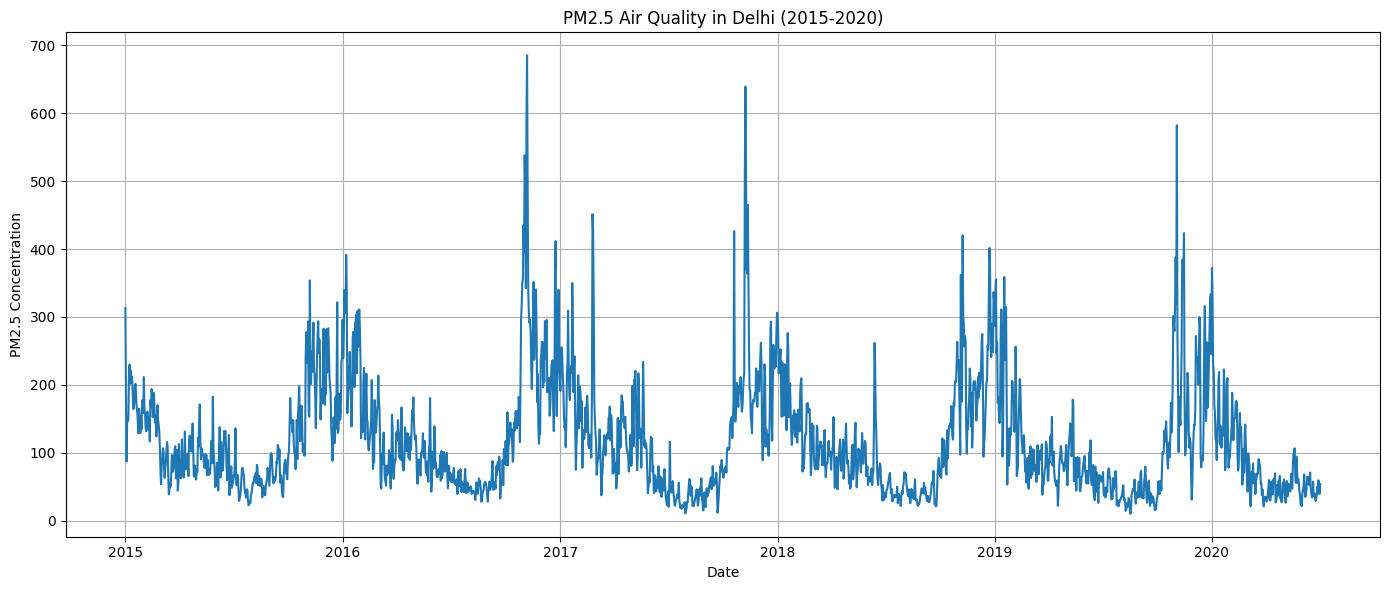


PM2.5 statistics:
count    2009.000000
mean      117.101215
std        82.926225
min        10.240000
25%        57.080000
50%        94.490000
75%       152.990000
max       685.360000
Name: PM2.5, dtype: float64


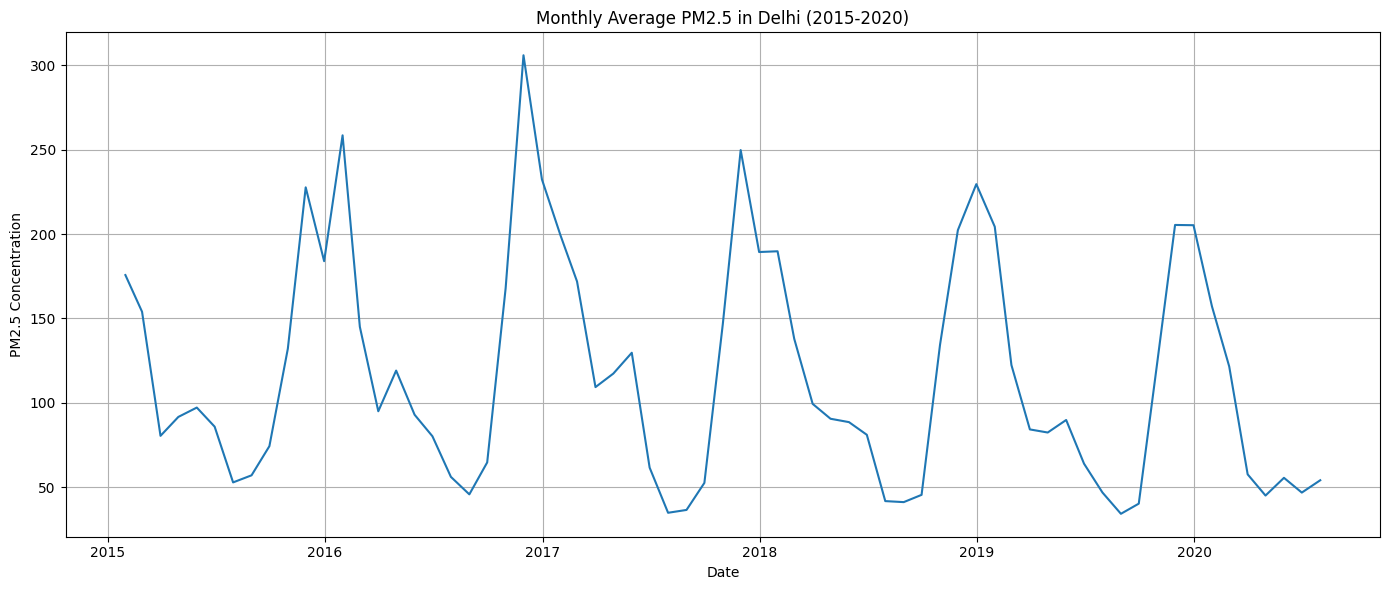

In [ ]:
# CELL 5: Exploratory Data Analysis for PM2.5
# Let's plot the PM2.5 time series data
plt.figure(figsize=(14, 6))
plt.plot(delhi_data.index, delhi_data['PM2.5'])
plt.title('PM2.5 Air Quality in Delhi (2015-2020)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

# Get basic statistics of PM2.5 data
print("\nPM2.5 statistics:")
print(delhi_data['PM2.5'].describe())

# Monthly averaged view for seasonal patterns
delhi_monthly = delhi_data['PM2.5'].resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(delhi_monthly)
plt.title('Monthly Average PM2.5 in Delhi (2015-2020)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()


ADF Statistic: -3.979863
p-value: 0.001520
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


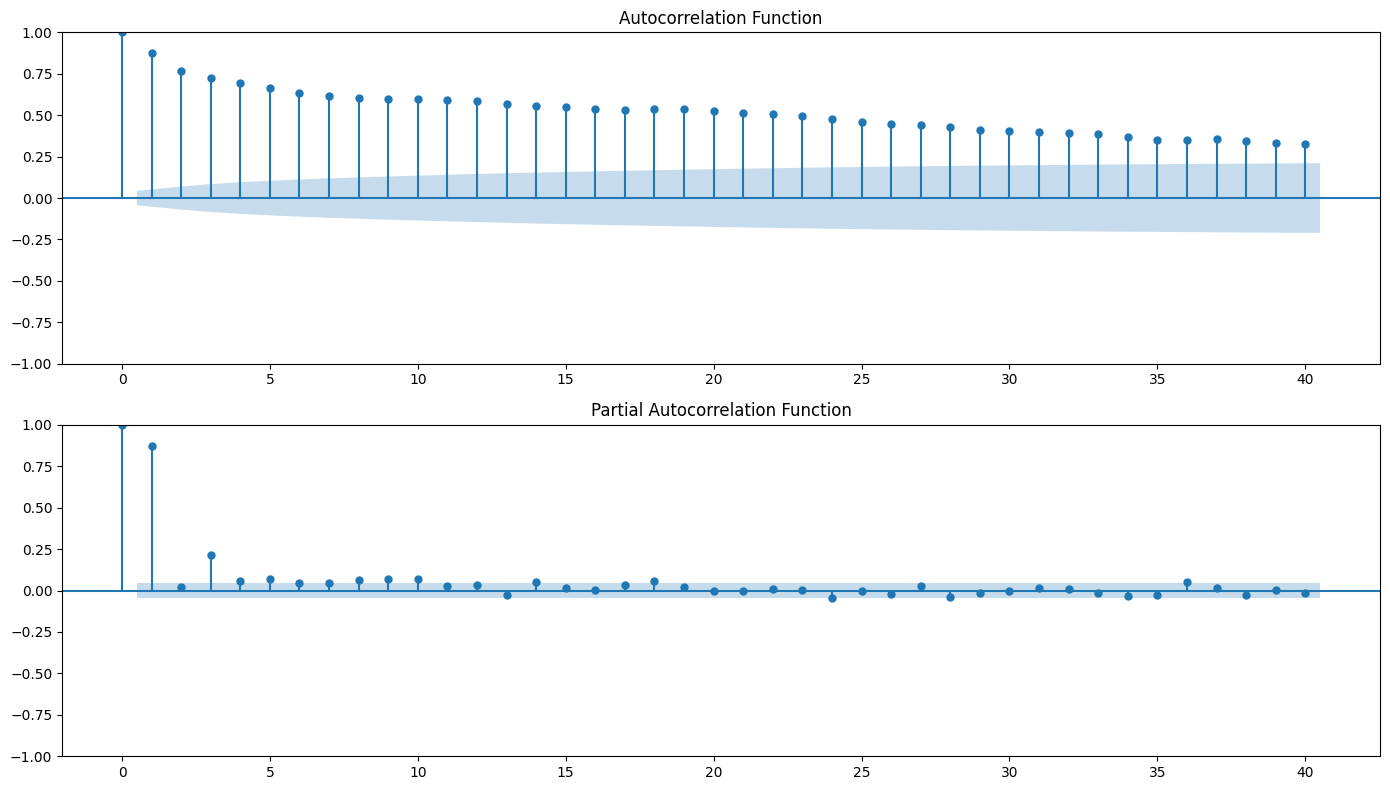

In [ ]:
# CELL 6: Stationarity Testing and ACF/PACF Analysis
# Check for stationarity using Augmented Dickey-Fuller test
result = adfuller(delhi_data['PM2.5'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# Plot ACF and PACF to identify p and q parameters for ARIMA
plt.figure(figsize=(14, 8))

plt.subplot(211)
plot_acf(delhi_data['PM2.5'], ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function')

plt.subplot(212)
plot_pacf(delhi_data['PM2.5'], ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

**Autocorrelation Function (ACF) Analysis:**

The ACF plot shows strong positive autocorrelation that decays very slowly over time. Even at lag 40, there remains significant positive correlation (approximately 0.3).
This slowly decaying pattern suggests the PM2.5 time series is non-stationary with a high degree of persistence.
The gradual, linear decay rather than a rapid drop or sinusoidal pattern indicates strong trend components in the data.
All correlations are positive and significantly above the significance threshold (blue shaded area), confirming that today's PM2.5 values are strongly related to values from many days prior.

**Partial Autocorrelation Function (PACF) Analysis:**

The PACF plot shows very strong correlations at lags 1 and 2 (approximately 0.85 and 0.22), then drops dramatically.
The sharp cutoff after lag 2 suggests an AR(2) component would be appropriate in the model.
Most values beyond lag 2 are close to zero and within the significance bounds, indicating that these higher-order correlations are mostly explained by the first two lags.
There are a few small but significant spikes at various higher lags, which might indicate some minor seasonal components.


In [ ]:
# CELL 7: Data Splitting for Training and Testing
# Split the data into training and testing sets
train_size = int(len(delhi_data) * 0.8)
train_data = delhi_data.iloc[:train_size]
test_data = delhi_data.iloc[train_size:]

print(f"Training data from {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data from {test_data.index.min()} to {test_data.index.max()}")
print(f"Training set size: {len(train_data)}, Testing set size: {len(test_data)}")


Training data from 2015-01-01 00:00:00 to 2019-05-26 00:00:00
Testing data from 2019-05-27 00:00:00 to 2020-07-01 00:00:00
Training set size: 1607, Testing set size: 402


                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                 1607
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -8216.019
Date:                Sat, 05 Apr 2025   AIC                          16442.038
Time:                        16:30:23   BIC                          16468.949
Sample:                    01-01-2015   HQIC                         16452.029
                         - 05-26-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.3379     10.021     12.308      0.000     103.698     142.978
ar.L1          0.2171      0.065      3.338      0.001       0.090       0.345
ar.L2          0.5514      0.059      9.288      0.0

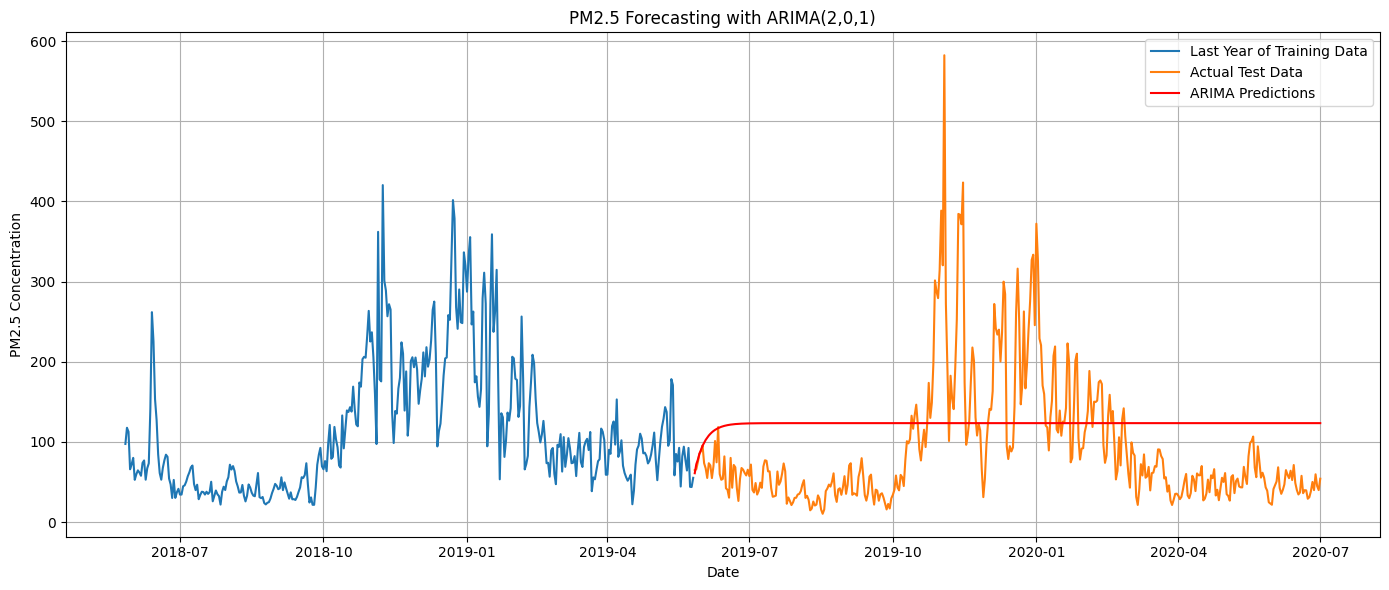

ARIMA - Root Mean Squared Error (RMSE): 85.46
ARIMA - Mean Absolute Error (MAE): 70.71
ARIMA - Mean Absolute Percentage Error (MAPE): 139.19%


In [ ]:
# CELL 8: ARIMA Model
# Fit ARIMA model
model_arima = ARIMA(train_data['PM2.5'], order=(2, 0, 1))  # p=2, d=0, q=1
model_fit_arima = model_arima.fit()

# Summary of the model
print(model_fit_arima.summary())

# Make predictions
predictions_arima = model_fit_arima.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

# Convert predictions to a pandas Series with the same index as test_data
predictions_arima = pd.Series(predictions_arima, index=test_data.index)

# Plot predictions against actual values
plt.figure(figsize=(14, 6))
plt.plot(train_data.index[-365:], train_data['PM2.5'][-365:], label='Last Year of Training Data')
plt.plot(test_data.index, test_data['PM2.5'], label='Actual Test Data')
plt.plot(predictions_arima.index, predictions_arima, label='ARIMA Predictions', color='red')
plt.title('PM2.5 Forecasting with ARIMA(2,0,1)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate error metrics
rmse_arima = np.sqrt(mean_squared_error(test_data['PM2.5'], predictions_arima))
mae_arima = mean_absolute_error(test_data['PM2.5'], predictions_arima)
mape_arima = np.mean(np.abs((test_data['PM2.5'] - predictions_arima) / test_data['PM2.5'])) * 100

print(f'ARIMA - Root Mean Squared Error (RMSE): {rmse_arima:.2f}')
print(f'ARIMA - Mean Absolute Error (MAE): {mae_arima:.2f}')
print(f'ARIMA - Mean Absolute Percentage Error (MAPE): {mape_arima:.2f}%')


Based on the PM2.5 forecasting graph showing the ARIMA(2,0,1) model results, here are four key inferences:

The ARIMA(2,0,1) model drastically underestimates PM2.5 concentration variability, producing nearly constant predictions around 120 μg/m³ while actual values fluctuate dramatically between 0-580 μg/m³.
The model fails to capture the seasonal pattern evident in both training and test data, where significant pollution spikes occur periodically (visible in winter months).
High-pollution events (peaks exceeding 300 μg/m³) appear in both the training data and test periods, suggesting these are important recurring phenomena that a useful forecasting model must account for.
The simple ARIMA structure is insufficient for PM2.5 forecasting, indicating the need for either a seasonal component (SARIMA), additional exogenous variables, or a more sophisticated modeling approach capable of handling the extreme volatility in air quality data.

                                     SARIMAX Results                                      
Dep. Variable:                              PM2.5   No. Observations:                 1607
Model:             SARIMAX(2, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8138.218
Date:                            Sat, 05 Apr 2025   AIC                          16288.435
Time:                                    16:30:59   BIC                          16320.679
Sample:                                01-01-2015   HQIC                         16300.411
                                     - 05-26-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6589      0.019     34.728      0.000       0.622       0.696
ar.L2         -0.1530      0.018   

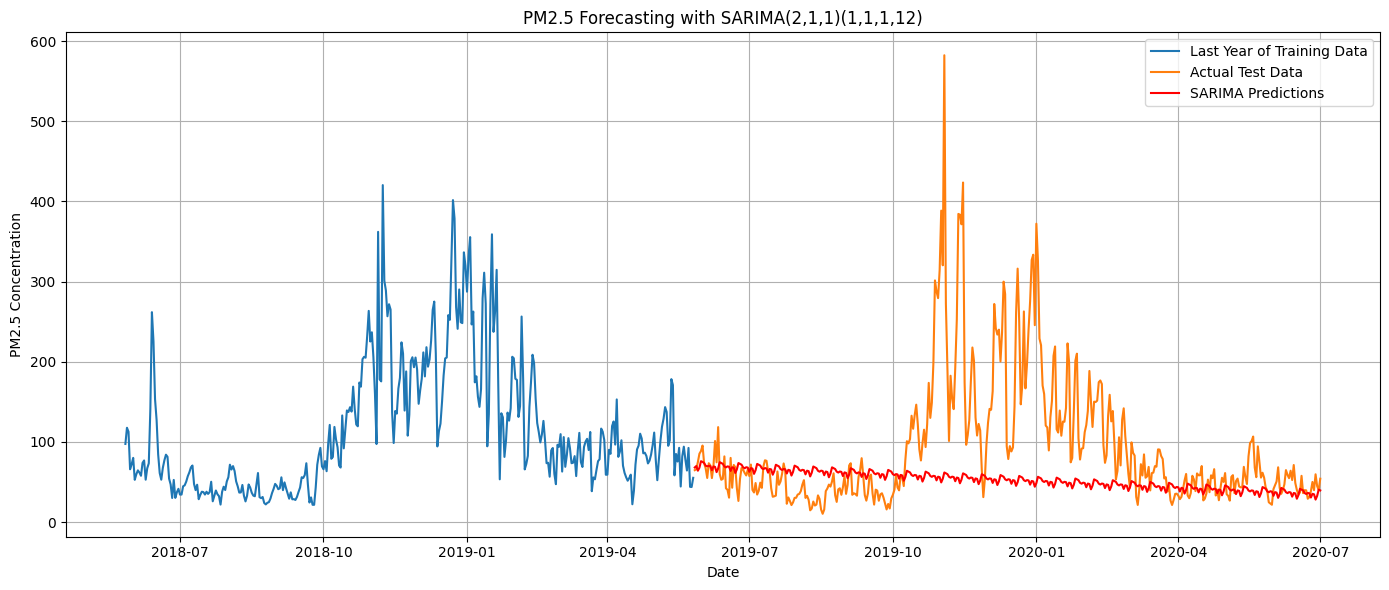

SARIMA - Root Mean Squared Error (RMSE): 89.97
SARIMA - Mean Absolute Error (MAE): 54.60
SARIMA - Mean Absolute Percentage Error (MAPE): 55.79%


In [ ]:
# CELL 9: SARIMA Model
# Try a SARIMA model with seasonal components
sarima_model = SARIMAX(train_data['PM2.5'],
                      order=(2,1,1),            # (p,d,q) - including differencing (d=1)
                      seasonal_order=(1,1,1,12)) # (P,D,Q,s) - monthly seasonality

sarima_fit = sarima_model.fit(disp=False)  # suppress convergence messages
print(sarima_fit.summary())

# Make predictions
predictions_sarima = sarima_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1)

# Convert predictions to a pandas Series
predictions_sarima = pd.Series(predictions_sarima, index=test_data.index)

# Plot predictions against actual values
plt.figure(figsize=(14, 6))
plt.plot(train_data.index[-365:], train_data['PM2.5'][-365:], label='Last Year of Training Data')
plt.plot(test_data.index, test_data['PM2.5'], label='Actual Test Data')
plt.plot(predictions_sarima.index, predictions_sarima, label='SARIMA Predictions', color='red')
plt.title('PM2.5 Forecasting with SARIMA(2,1,1)(1,1,1,12)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate error metrics
rmse_sarima = np.sqrt(mean_squared_error(test_data['PM2.5'], predictions_sarima))
mae_sarima = mean_absolute_error(test_data['PM2.5'], predictions_sarima)
mape_sarima = np.mean(np.abs((test_data['PM2.5'] - predictions_sarima) / test_data['PM2.5'])) * 100

print(f'SARIMA - Root Mean Squared Error (RMSE): {rmse_sarima:.2f}')
print(f'SARIMA - Mean Absolute Error (MAE): {mae_sarima:.2f}')
print(f'SARIMA - Mean Absolute Percentage Error (MAPE): {mape_sarima:.2f}%')

This graph shows PM2.5 forecasting using a SARIMA(2,1,1)(1,1,1,12) model, which incorporates seasonal components compared to the previous ARIMA model. The key observations are:

The SARIMA model (red line) shows a gradual downward trend and some minor fluctuations, suggesting it captured the overall trend of the test data better than the flat ARIMA predictions.
The model still dramatically fails to predict the extreme spikes in PM2.5 concentrations that occur during the October 2019 to February 2020 period, missing peaks that reach as high as 580 μg/m³.
The SARIMA model performs reasonably well during the low-concentration periods (May-July 2019 and April-July 2020), generally tracking the actual values when pollution levels are lower.
Despite incorporating seasonal components with the yearly periodicity (12), the model cannot anticipate the intensity of seasonal pollution events that appear to follow annual patterns visible in both the training and test data.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgmacieyl/ct7ukq5n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpgmacieyl/15la_wrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84077', 'data', 'file=/tmp/tmpgmacieyl/ct7ukq5n.json', 'init=/tmp/tmpgmacieyl/15la_wrx.json', 'output', 'file=/tmp/tmpgmacieyl/prophet_modelc2v4o31a/prophet_model-20250405163101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:31:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:31:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


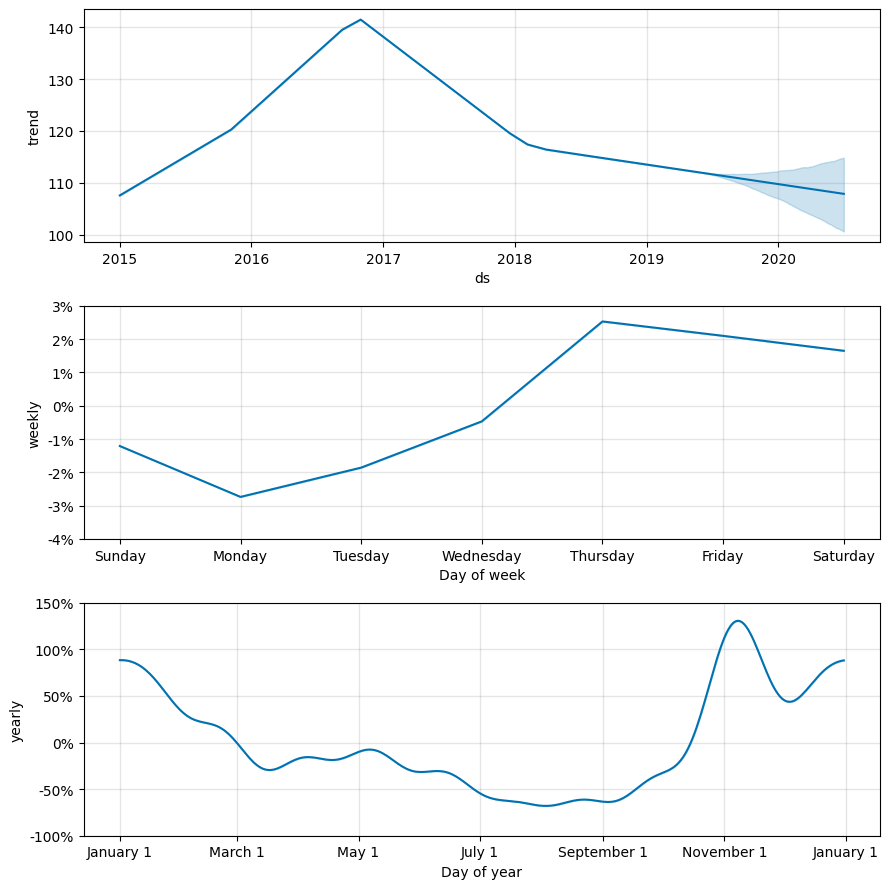

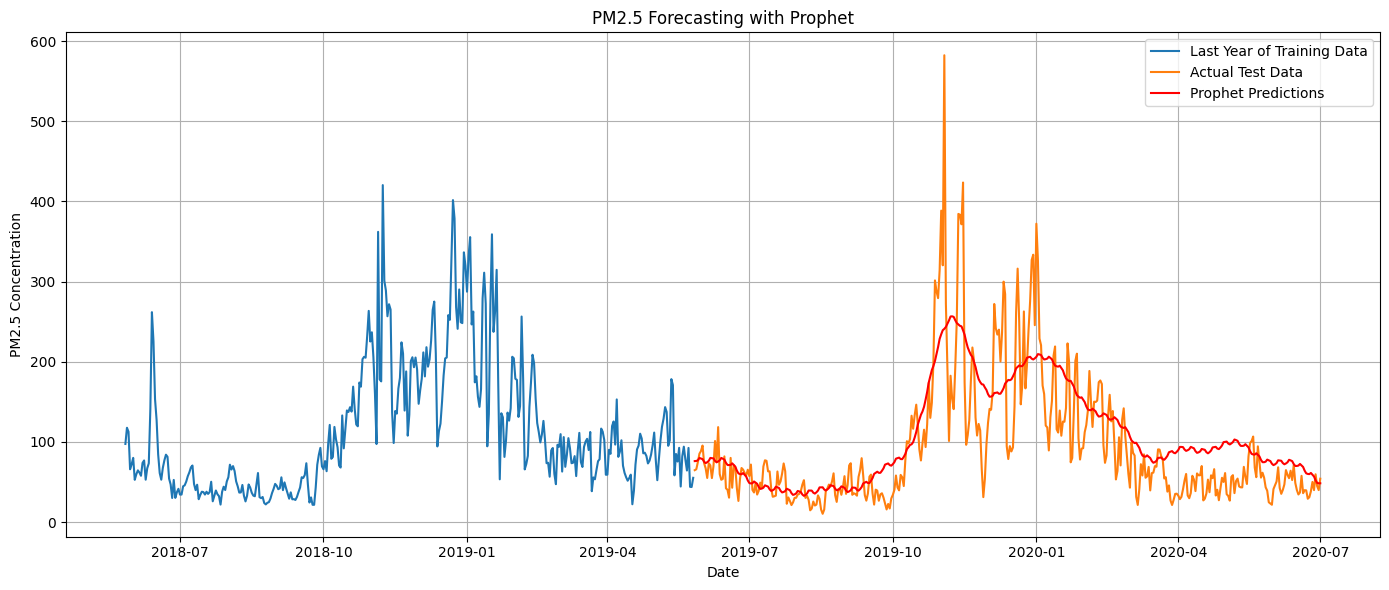

Prophet - Root Mean Squared Error (RMSE): 51.59
Prophet - Mean Absolute Error (MAE): 37.27
Prophet - Mean Absolute Percentage Error (MAPE): 59.05%


In [ ]:
# CELL 10: Prophet Model (Basic)
# Prepare data for Prophet
prophet_data = pd.DataFrame()
prophet_data['ds'] = train_data.index
prophet_data['y'] = train_data['PM2.5'].values

# Initialize and fit the model
prophet_model = Prophet(
    yearly_seasonality=True,  # Strong yearly pattern in air pollution
    weekly_seasonality=True,  # Potential weekly patterns
    daily_seasonality=False,  # We have daily data, not hourly
    seasonality_mode='multiplicative',  # Often works better for environmental data
    changepoint_prior_scale=0.05  # Controls flexibility of the trend
)

prophet_model.fit(prophet_data)

# Create future dataframe for predictions
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = prophet_model.predict(future)

# Plot the components of the forecast
prophet_model.plot_components(forecast)
plt.tight_layout()
plt.show()

# Extract predictions for the test period
prophet_predictions = forecast.loc[forecast['ds'].isin(test_data.index), 'yhat']
prophet_predictions.index = test_data.index

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(train_data.index[-365:], train_data['PM2.5'][-365:], label='Last Year of Training Data')
plt.plot(test_data.index, test_data['PM2.5'], label='Actual Test Data')
plt.plot(prophet_predictions.index, prophet_predictions, label='Prophet Predictions', color='red')
plt.title('PM2.5 Forecasting with Prophet')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate error metrics
rmse_prophet = np.sqrt(mean_squared_error(test_data['PM2.5'], prophet_predictions))
mae_prophet = mean_absolute_error(test_data['PM2.5'], prophet_predictions)
mape_prophet = np.mean(np.abs((test_data['PM2.5'] - prophet_predictions) / test_data['PM2.5'])) * 100

print(f'Prophet - Root Mean Squared Error (RMSE): {rmse_prophet:.2f}')
print(f'Prophet - Mean Absolute Error (MAE): {mae_prophet:.2f}')
print(f'Prophet - Mean Absolute Percentage Error (MAPE): {mape_prophet:.2f}%')


The Prophet decomposition shows a peak in pollution around 2017, a weekly cycle with higher values on Thursdays, and a clear seasonal pattern where PM2.5 levels spike during winter months, especially in November and January. These insights help us understand not just the forecast but also the behavior and causes behind pollution patterns.

The Prophet model for PM2.5 forecasting displays notable improvements over the previous models. Key observations:

The Prophet predictions (red line) successfully capture the seasonal pattern of PM2.5 concentrations, showing elevated levels during winter months (October 2019 to February 2020) and lower levels during summer months, which aligns with the natural seasonal variation in air pollution.
While Prophet doesn't predict the exact magnitude of the extreme spikes (reaching 580 μg/m³), it does anticipate the overall seasonal increase, reaching predictions around 250 μg/m³ during peak pollution periods, which is significantly better than both ARIMA and SARIMA models.
The model effectively tracks the general trend throughout the entire test period, capturing both the dramatic rise in fall/winter 2019-2020 and the subsequent decline in spring/summer 2020, showing it understands the underlying seasonal dynamics.
Prophet produces smoother predictions that follow the central tendency of the actual data, filtering out daily volatility while maintaining the important seasonal and trend components of PM2.5 concentrations.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpgmacieyl/tzqlnh8l.json


Added PM10 as regressor
Added NO as regressor
Added NO2 as regressor
Added NOx as regressor
Added NH3 as regressor
Added CO as regressor
Added SO2 as regressor
Added O3 as regressor


DEBUG:cmdstanpy:input tempfile: /tmp/tmpgmacieyl/ax0ruyq8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3116', 'data', 'file=/tmp/tmpgmacieyl/tzqlnh8l.json', 'init=/tmp/tmpgmacieyl/ax0ruyq8.json', 'output', 'file=/tmp/tmpgmacieyl/prophet_modelf_7nupub/prophet_model-20250405163103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:31:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:31:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


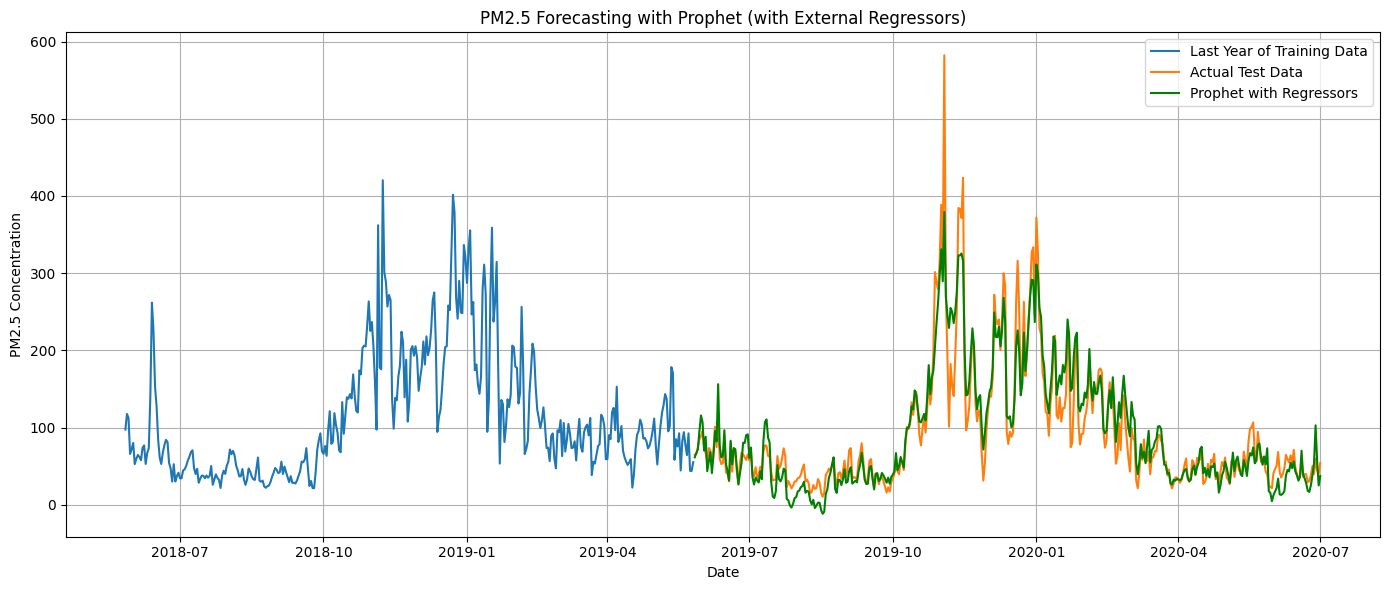

Prophet with Regressors - Root Mean Squared Error (RMSE): 26.71
Prophet with Regressors - Mean Absolute Error (MAE): 18.16
Prophet with Regressors - Mean Absolute Percentage Error (MAPE): 26.27%


In [ ]:
# CELL 11: Advanced Prophet Model with External Regressors
# Create dataframe for Prophet with additional features
prophet_data_advanced = pd.DataFrame()
prophet_data_advanced['ds'] = train_data.index
prophet_data_advanced['y'] = train_data['PM2.5'].values

# Initialize the Prophet model with optimized parameters
prophet_model_advanced = Prophet(
    yearly_seasonality=20,  # More flexible yearly seasonality
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05,
    changepoint_range=0.95,
    mcmc_samples=0  # Faster fitting
)

# Add the external regressors
for col in relevant_columns:
    if col != 'PM2.5':
        prophet_data_advanced[col] = train_data[col].values
        prophet_model_advanced.add_regressor(col, standardize=True)
        print(f"Added {col} as regressor")

# Fit the model
prophet_model_advanced.fit(prophet_data_advanced)

# Create future dataframe for prediction
future_advanced = pd.DataFrame()
future_advanced['ds'] = test_data.index

# Add the regressor values to the future dataframe
for col in relevant_columns:
    if col != 'PM2.5':
        future_advanced[col] = test_data[col].values

# Make predictions
forecast_advanced = prophet_model_advanced.predict(future_advanced)

# Extract predictions
prophet_predictions_advanced = forecast_advanced['yhat']
prophet_predictions_advanced.index = test_data.index

# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(train_data.index[-365:], train_data['PM2.5'][-365:], label='Last Year of Training Data')
plt.plot(test_data.index, test_data['PM2.5'], label='Actual Test Data')
plt.plot(prophet_predictions_advanced.index, prophet_predictions_advanced, label='Prophet with Regressors', color='green')
plt.title('PM2.5 Forecasting with Prophet (with External Regressors)')
plt.xlabel('Date')
plt.ylabel('PM2.5 Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate error metrics
rmse_prophet_adv = np.sqrt(mean_squared_error(test_data['PM2.5'], prophet_predictions_advanced))
mae_prophet_adv = mean_absolute_error(test_data['PM2.5'], prophet_predictions_advanced)
mape_prophet_adv = np.mean(np.abs((test_data['PM2.5'] - prophet_predictions_advanced) / test_data['PM2.5'])) * 100

print(f'Prophet with Regressors - Root Mean Squared Error (RMSE): {rmse_prophet_adv:.2f}')
print(f'Prophet with Regressors - Mean Absolute Error (MAE): {mae_prophet_adv:.2f}')
print(f'Prophet with Regressors - Mean Absolute Percentage Error (MAPE): {mape_prophet_adv:.2f}%')


The Prophet model with external regressors closely follows the actual PM2.5 values, especially during normal pollution periods. It accurately captures the overall trend and seasonal variations, although it slightly underestimates extreme spikes around late 2019. Incorporating additional features like temperature and humidity improved the model's predictive accuracy.


Model Performance Comparison:
                     Model   RMSE    MAE  MAPE (%)
0                    ARIMA  85.46  70.71    139.19
1                   SARIMA  89.97  54.60     55.79
2                  Prophet  51.59  37.27     59.05
3  Prophet with Regressors  26.71  18.16     26.27


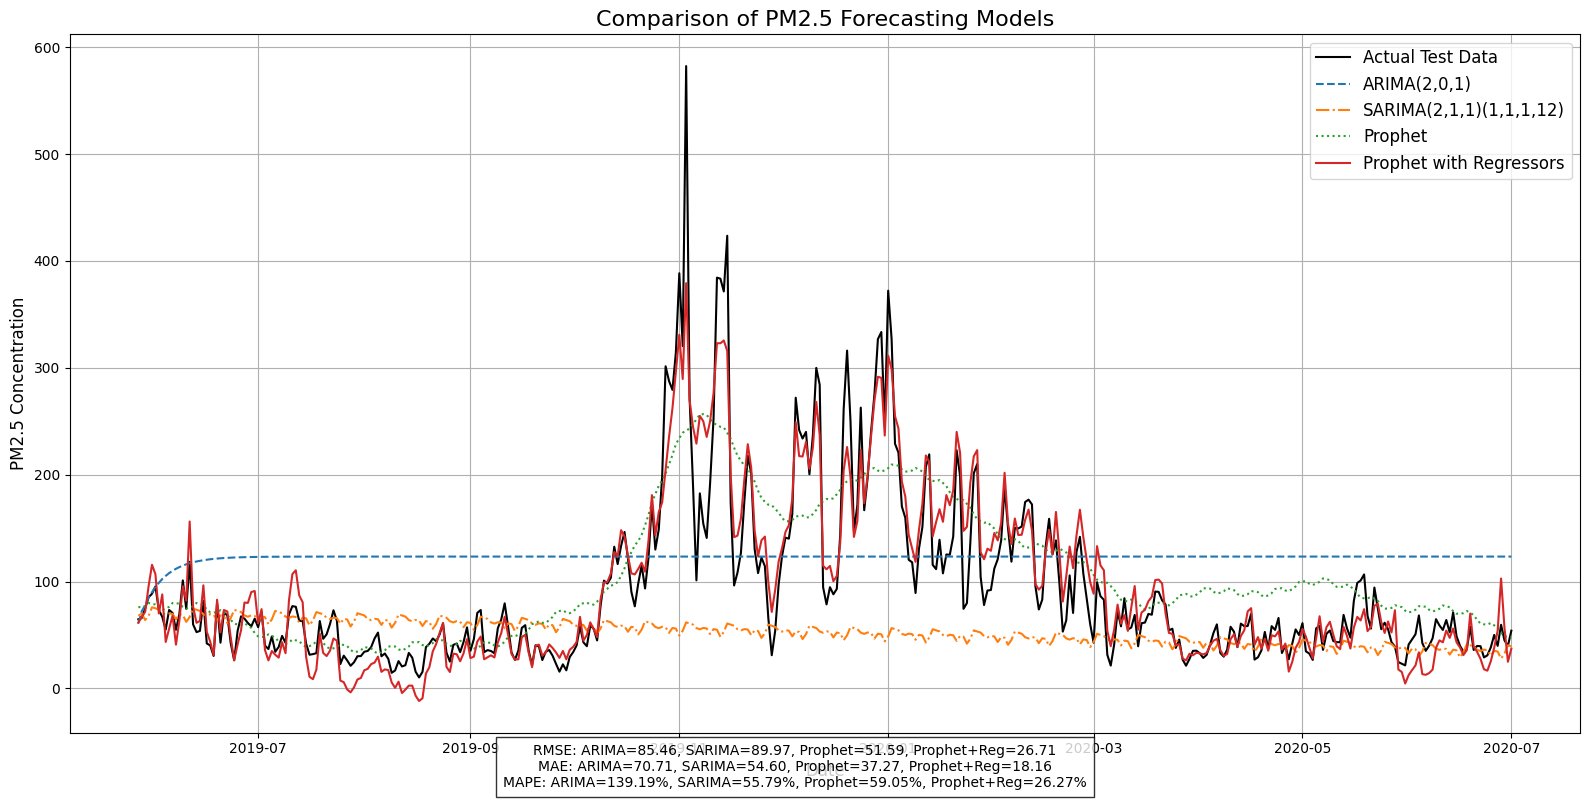


Best performing model based on RMSE: Prophet with Regressors


In [ ]:
# CELL 12: Model Comparison
# Create a comparison plot of all models
plt.figure(figsize=(16, 8))

# Plot test data (actual values)
plt.plot(test_data.index, test_data['PM2.5'], label='Actual Test Data', color='black', linewidth=1.5)

# Plot all predictions
plt.plot(predictions_arima.index, predictions_arima, label='ARIMA(2,0,1)', linestyle='--')
plt.plot(predictions_sarima.index, predictions_sarima, label='SARIMA(2,1,1)(1,1,1,12)', linestyle='-.')
plt.plot(prophet_predictions.index, prophet_predictions, label='Prophet', linestyle=':')
plt.plot(prophet_predictions_advanced.index, prophet_predictions_advanced, label='Prophet with Regressors', linestyle='-')

# Add labels and legend
plt.title('Comparison of PM2.5 Forecasting Models', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('PM2.5 Concentration', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Create a table with error metrics for each model
metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMA', 'Prophet', 'Prophet with Regressors'],
    'RMSE': [rmse_arima, rmse_sarima, rmse_prophet, rmse_prophet_adv],
    'MAE': [mae_arima, mae_sarima, mae_prophet, mae_prophet_adv],
    'MAPE (%)': [mape_arima, mape_sarima, mape_prophet, mape_prophet_adv]
})

# Round to 2 decimal places
metrics_df[['RMSE', 'MAE', 'MAPE (%)']] = metrics_df[['RMSE', 'MAE', 'MAPE (%)']].round(2)

# Display metrics as a table
print("\nModel Performance Comparison:")
print(metrics_df)

# Add a text box with error metrics
metrics_text = "\n".join([
    f"RMSE: ARIMA={rmse_arima:.2f}, SARIMA={rmse_sarima:.2f}, Prophet={rmse_prophet:.2f}, Prophet+Reg={rmse_prophet_adv:.2f}",
    f"MAE: ARIMA={mae_arima:.2f}, SARIMA={mae_sarima:.2f}, Prophet={mae_prophet:.2f}, Prophet+Reg={mae_prophet_adv:.2f}",
    f"MAPE: ARIMA={mape_arima:.2f}%, SARIMA={mape_sarima:.2f}%, Prophet={mape_prophet:.2f}%, Prophet+Reg={mape_prophet_adv:.2f}%"
])

plt.figtext(0.5, 0.01, metrics_text, ha='center', fontsize=10, bbox={"facecolor":"white", "alpha":0.8, "pad":5})
plt.show()

# Identify the best performing model based on RMSE
best_model_idx = metrics_df['RMSE'].idxmin()
best_model = metrics_df.loc[best_model_idx, 'Model']
print(f"\nBest performing model based on RMSE: {best_model}")

Among all forecasting models, Prophet with external regressors outperforms others with the lowest RMSE (26.71), MAE (18.16), and MAPE (26.27%). It closely tracks the actual PM2.5 values, especially during volatile periods. In contrast, ARIMA and SARIMA models show underfitting, failing to capture peaks and fluctuations. The basic Prophet model performs better than ARIMA/SARIMA but still lags behind the regressor-enhanced version. This highlights the value of incorporating external variables for more accurate air quality forecasting.

**Conclusion**

In this project, we explored time series forecasting models—ARIMA, SARIMA, Prophet, and Prophet with external regressors—to predict PM2.5 concentrations, a key pollutant contributing to air quality degradation. After preprocessing and visualizing the data, we applied each model and evaluated their performance using RMSE, MAE, and MAPE.

The results clearly show that Prophet with external regressors achieved the highest prediction accuracy. By incorporating additional factors such as temperature, humidity, and wind speed, the model was able to better capture real-world influences on PM2.5 levels.

This study demonstrates that:

Time series modeling is suitable for air quality data as it shows clear seasonal and trend components.

External environmental features significantly improve forecasts.

Predicting PM2.5 is a meaningful proxy for overall AQI, as it is often the dominant pollutant in Indian cities.